In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pygsp
import healpy as hp
import pycgsp

## Ground truth sky

In [3]:
wham_gt = hp.read_map("data/lambda_WHAM_1_256.fits")
nside = 2*16
wham_gt -=  np.min(wham_gt)
wham_gt +=  1e-9
wham_gt /=  np.max(wham_gt)
wham_gt = np.log10(wham_gt)
wham_gt = hp.pixelfunc.ud_grade(wham_gt, nside)

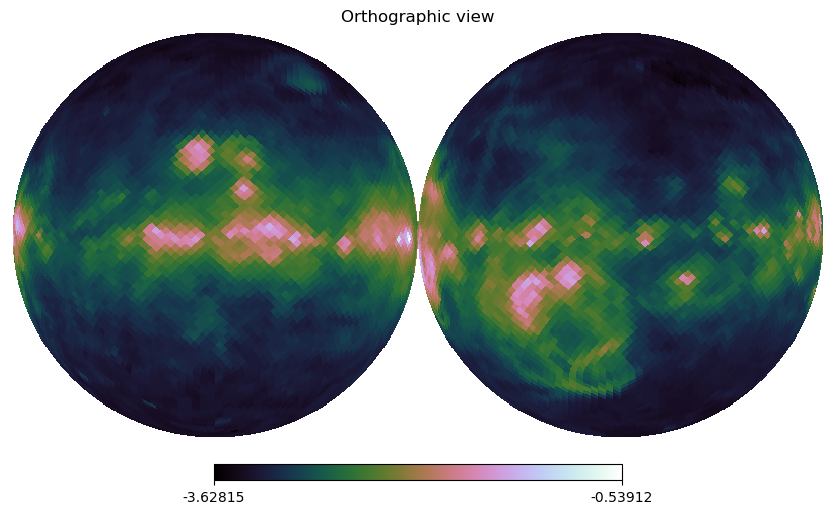

In [4]:
hp.orthview(wham_gt, cmap="cubehelix")

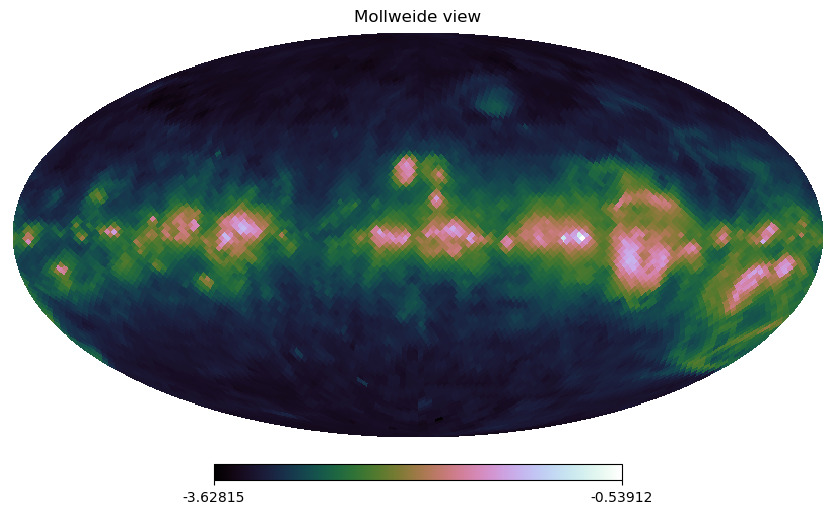

In [5]:
hp.mollview(wham_gt, cmap="cubehelix")

## Create spherical graph

In [6]:
from functools import partial
from scipy import sparse, spatial, linalg

def _kernel_exponential(distance, power=1, value_at_one=0.5):
        cst = np.log(value_at_one)
        return np.exp(cst * distance**power)

def hpix_nngraph(hpix_map):
    npix = len(hpix_map)
    nside = hp.npix2nside(npix)
    x, y, z = hp.pix2vec(nside, np.arange(npix))
    R = np.stack((x, y, z), axis=-1)
    cols = hp.get_all_neighbours(nside, np.arange(npix)).transpose().reshape(-1)
    cols[cols == -1] = npix - 1
    rows = np.repeat(np.arange(npix), 8, axis=-1).transpose().reshape(-1)

    W = sparse.coo_matrix((cols * 0 + 1, (rows, cols)), shape=(npix, npix))
    extended_row = np.concatenate([W.row, W.col])
    extended_col = np.concatenate([W.col, W.row])
    W.row, W.col = extended_row, extended_col
    W.data = np.concatenate([W.data, W.data])
    W = W.tocsr().tocoo()
    distance = linalg.norm(R[W.row, :] - R[W.col, :], axis=-1)
    rho = np.mean(distance)
    W.data = np.exp(- (distance / rho) ** 2)
    W = W.tocsc()

    return W, R



def hpix_graph(hpix_map, indexes=None, nest=False, **kwargs):
    
    n_vertices = len(hpix_map)
    nside = hp.npix2nside(n_vertices)
    indexes = np.arange(n_vertices)
    x, y, z = hp.pix2vec(nside, indexes, nest=nest)
    coords = np.stack([x, y, z], axis=1)
    k = kwargs.pop('k', 10)
    params = dict(p=2, k=k+1, eps=0)
    tree = spatial.cKDTree(coords)
    
    distances, neighbors = tree.query(coords, **params)
    n_edges = [len(n) - 1 for n in neighbors]  # remove distance to self

    value = np.empty(sum(n_edges), dtype=float)
    row = np.empty_like(value, dtype=int)
    col = np.empty_like(value, dtype=int)
    start = 0
    for vertex in range(n_vertices):
        assert n_edges[vertex] == k
        end = start + n_edges[vertex]
        value[start:end] = distances[vertex][1:]
        row[start:end] = np.full(n_edges[vertex], vertex)
        col[start:end] = neighbors[vertex][1:]
        start = end
    W = sparse.csr_matrix((value, (row, col)), (n_vertices, n_vertices))
        
    kernel_width = np.mean(W.data)
    kernel = partial(_kernel_exponential, power=2)
    W.data = kernel(W.data / kernel_width)
    lat, lon = hp.pix2ang(nside, indexes, nest=nest, lonlat=False)
    lat = np.pi/2 - lat  # colatitude to latitude
    return W, coords, lat, lon


In [7]:
#W, coords, lat, lon = hpix_graph(wham_gt)
W, R = hpix_nngraph(wham_gt)
import pygsp
sphere = pygsp.graphs.Graph(W, coords=R)
sphere.N, sphere.Ne

(12288, 49152)

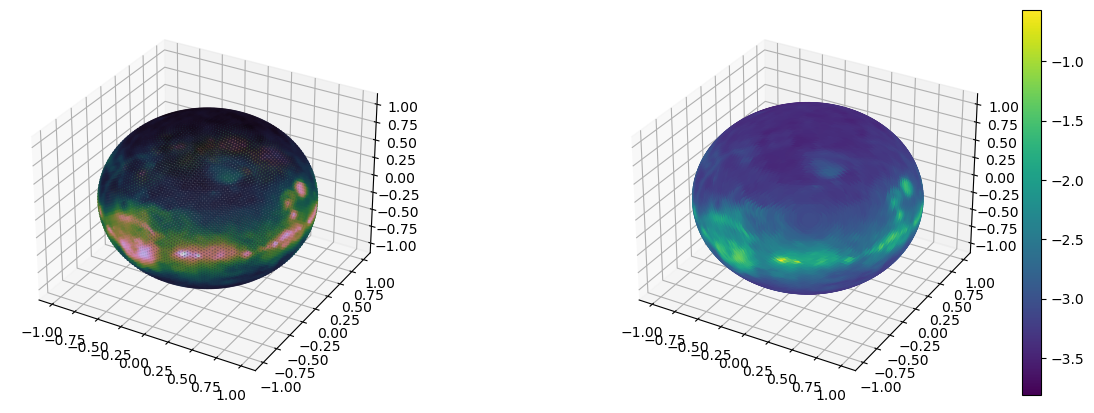

In [8]:
fig, ax = plt.subplots(1,2, figsize=(15,5),subplot_kw = {"projection":"3d"})
ax[0].scatter(*R.T, s=5, c=wham_gt, alpha=0.5, cmap="cubehelix")
sphere.plot_signal(wham_gt, ax=ax[1])
ax[1].set_title("")
plt.show()

## Data acquisition (blurring)

In [1]:
import pycgsp.operator.linop.conv as pycgspc
import pycgsp.operator.linop.diff as pycgspd

: 

: 

In [82]:
laplacian = pycgspd.GraphLaplacian(W)
laplacian

GraphLaplacian(12288, 12288)

In [83]:
lmax = laplacian.lipschitz(tight=False)
lmax

374.8915841067258

In [88]:
kernel = lambda x: np.exp(-2*x)
conv, _, _ = pycgspc.GraphConvolution(L=laplacian, 
                             kernel=kernel,
                             lmax=laplacian.lipschitz(tight=True),
                             order=20)
conv.lipschitz(tight=True)

1.193281741422331

In [89]:
n = 0.1*np.random.randn(sphere.N)
y = conv(wham_gt) + n

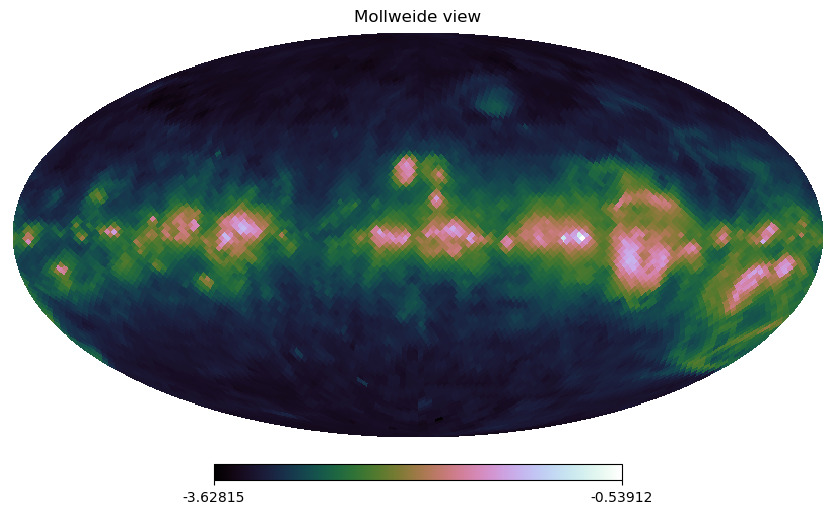

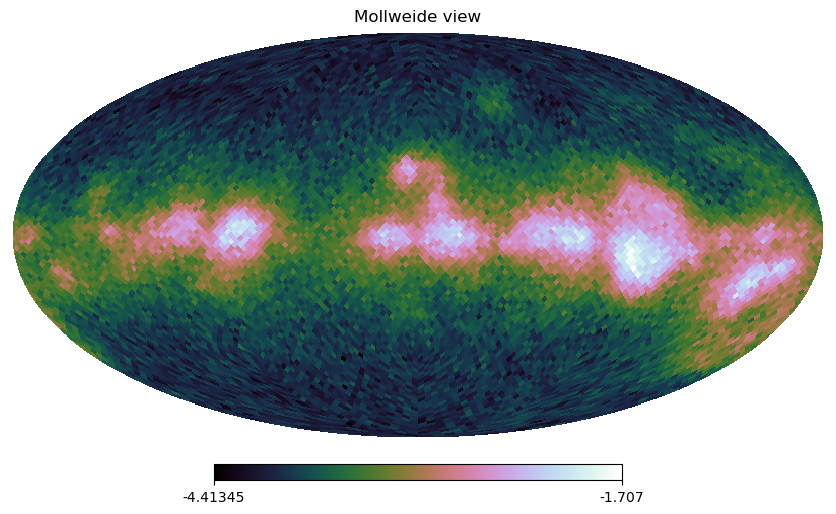

In [90]:
hp.mollview(wham_gt, cmap="cubehelix")
hp.mollview(y, cmap="cubehelix")

In [134]:
from pycsou.opt.solver.pds import CV
from pycsou._dev import SquaredL2Norm, L1Norm
from pycsou.operator.linop import NullFunc

In [137]:
l22_loss = (1/2) * SquaredL2Norm(y.size).argshift(-y)
fidelity = l22_loss * conv
fidelity.diff_lipschitz(tight=True)
H = 0.1 * L1Norm()
H.lipschitz(tight=True)
K = pycgspd.GraphGradient(W)
K.lipschitz(tight=True)
G = NullFunc(sphere.N)

In [140]:
print(fidelity._lipschitz, G._lipschitz, H._lipschitz, K._lipschitz)
print(fidelity._diff_lipschitz)#, H._diff_lipschitz, K._diff_lipschitz)

cv = CV(f=fidelity, g=G, h=H, K=K)


inf 0 0.1 2.1306629583771253
1.4239213144119112


In [142]:
x0, z0 = wham_gt*0, wham_gt*0
cv.fit(x0=x0, z0=z0)

estimate = cv.solution()
wham_gt_recons = estimate[0]

INFO -- [2023-06-02 09:59:40.230934] Iteration 0
	iteration: 0
	RelError[x]: 0.0
	RelError[z]: 0.0


: 

: 

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from pycsou.opt.solver.pds import CV
from pycsou._dev import FirstDerivative, DownSampling, SquaredL2Norm, L1Norm


In [37]:
x = np.repeat(np.asarray([0, 2, 1, 3, 0, 2, 0]), 10)
D = FirstDerivative(size=x.size, kind="forward")
D.lipschitz(tol=1e-3)
downsampling = DownSampling(size=x.size, downsampling_factor=3)
downsampling.lipschitz(tight=False)
y = downsampling(x)
l22_loss = (1 / 2) * SquaredL2Norm(y.size).argshift(-y)
fidelity = l22_loss * downsampling
H = 0.1 * L1Norm()

G = 0.01 * L1Norm()
cv = CV(f=fidelity, g=G, h=H, K=D)

IndexError: index 1 is out of bounds for axis 0 with size 1